# Builder Tutorial number 2

The builder tutorials demonstrate how to build an operational GSFLOW model using `pyGSFLOW` from shapefile, DEM, and other common data sources. These tutorials focus on the `gsflow.builder` classes.

## Resampling raster data to modelgrid discretization

In this tutorial, we demonstrate how to resample raster data to the "modelgrid" discretization for use in building new GSFLOW models. The primary focus of this tutorial is on resampling DEM data, however any raster data (e.g., vegetative cover, impervious area, soil data) can be used with these methods.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import flopy
from gsflow.builder import GenerateFishnet

## The `Raster` class

The `Raster` class is a FloPy utility for cropping, sampling, and resampling raster data. This tutorial will give a brief overview. For a complete overview please see [the flopy example notebooks](https://github.com/modflowpy/flopy/tree/develop/examples/Notebooks).

The `Raster` class loads raster information using the `Raster.load()` method

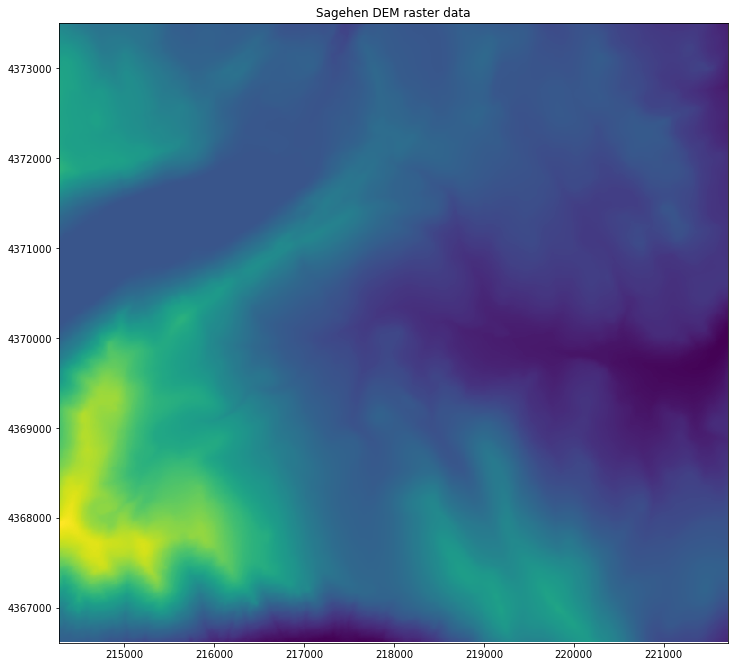

In [2]:
raster = os.path.join('data', 'geospatial', 'dem.img')

robj = flopy.utils.Raster.load(raster)

# plot the raster
fig, ax = plt.subplots(figsize=(12, 12))

robj.plot(ax=ax)
ax.set_title("Sagehen DEM raster data");

### Resampling a raster

Before resampling a raster the user needs to create a modelgrid (see pygsflow1.1.0_Builder_tutorial_1_fishnet.ipynb) or load a saved binary modelgrid file.

Once a modelgrid has been loaded, the resample_to_grid() method can be used to re-sample the data to an array consistent with the model grid.

Inputs to resample_to_grid() include:

   - `modelgrid` : flopy Grid object
   - `band` : raster band to resample
   - `method` : resampling method, options include:
      - `"nearest"` for nearest neighbor
      - `"linear"` for bilinear sampling
      - `"cubic"` for bicubic sampling
      - `"mean"` for mean value sampling
      - `"median"` for median value sampling
      - `"min"` for minimum value sampling
      - `"max"` for maximum value sampling
   - `multithread` : boolean flag to enable multithreading. This is only implemented for "mean" and "median" resampling and it's use is highly reccomended.
   - `thread_pool` : number of threads to use while multithreading
   - `extrapolate_edges` : boolean flag to extrapolate edges using the "nearest" resampling method. For all of the sampling methods except "nearest", interpolation is only performed in areas bounded by data; nodata values are returned in areas without data. This option has no effect when the "nearest" interpolation method is used.
   
**Nearest neighbor is the quickest method for resampling and mean/median/min/max are the slowest methods.**  
Note: Bottlenecks in sampling time depend on the resampling method used:

`"nearest"`, `"linear"`, and `"cubic"` bottlenecks are due to raster resolution.  
`"mean"`, `"median"`, `"min"`, and `"max"` are a function of the number of grid cells. It is highly reccomended to use multithreading with these methods

In [3]:
# generate a dummy modelgrid
modelgrid = GenerateFishnet(raster, xcellsize=50, ycellsize=150)

# now resample the loaded raster to an array of dimension nrow, ncol
array = robj.resample_to_grid(modelgrid, robj.bands[0], method="nearest")

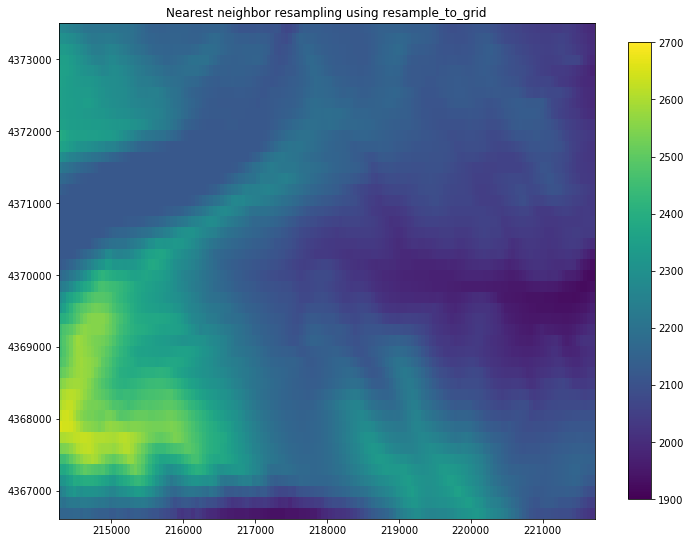

In [4]:
# now to visualize using flopy and matplotlib
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
ax = pmv.plot_array(
    array, masked_values=robj.nodatavals, vmin=1900, vmax=2700
)
plt.title("Nearest neighbor resampling using resample_to_grid")
plt.colorbar(ax, shrink=0.7);

## Applying `Raster` to build the Sagehen 50m example problem

In this section we apply `Raster` and it's `resample_to_grid()` method to build the discretized DEM representation for the Sagehen 50m example problem. This resampled DEM will be used many times in the model building process.

In [5]:
# Load the binary modelgrid file
mg_file = os.path.join("data", "sagehen", "50m_tutorials", "sagehen_50m_grid.bin")

modelgrid = GenerateFishnet.load_from_file(mg_file)

Now that the modelgrid is loaded, the DEM raster can be resampled

In [6]:
robj = flopy.utils.Raster.load(raster)

# use multithreading with "median" method to improve speed, 
# this however still takes time and is the bottleneck in the model building process
dem_data = robj.resample_to_grid(
    modelgrid, 
    robj.bands[0], 
    method="median", 
    multithread=True, 
    thread_pool=12
)

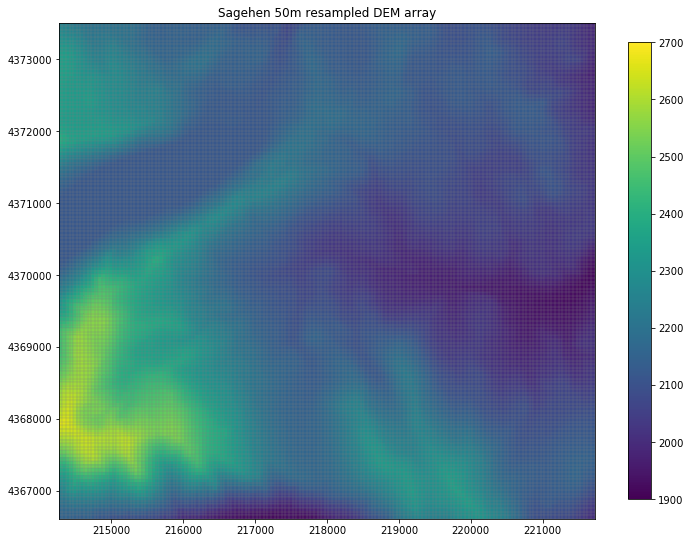

In [7]:
# plot the resampled DEM with the modelgrid overlain
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
ax = pmv.plot_array(
    dem_data, masked_values=robj.nodatavals, vmin=1900, vmax=2700
)
lc = pmv.plot_grid(color="grey", lw=0.3)
plt.title("Sagehen 50m resampled DEM array")
plt.colorbar(ax, shrink=0.7);

### Save the resampled DEM data for later use

The dem data can be saved for later use in the building process using numpy's `savetxt()` method.

**It's highly recommended to save the resampled dem data to avoid resampling during each step of the model building process.**

In [8]:
dem_file = os.path.join("data", "temp", "sagehen_50m_dem_median.txt")

np.savetxt(dem_file, dem_data, delimiter="  ")